In [51]:
import numpy as np
import math
import os
import glob
import pandas as pd
from pylab import *
from netCDF4 import Dataset
import pylab as pl
from mpl_toolkits.basemap import Basemap,shiftgrid,cm
import matplotlib.cm as cm
from scipy.stats import f as scist

import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
% matplotlib inline

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c

x = np.linspace(0,4,50)
y = func(x, 2.5, 1.3, 0.5)
yn = y + 0.2*np.random.normal(size=len(x))

popt, pcov = curve_fit(func, x, yn)

#Fitting the part. Th

In [53]:
import glob,csv
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/*.csv'))
print len(nc_filename)
print("found *.csv file: \n{}".format(nc_filename))

20
found *.csv file: 
['/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/1_ref5.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_1.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/23_4.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60changed.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60changed2.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiaoxiny/research/data/findk/All_Arctic-data/WLS/Th/60changed3.Th-Pa_data_July2012-Oceanic-U-Series-and-REE-Database.csv', '/ocean/xiao

In [54]:
file_num=12
marker=['>','o','o','o','o','s','s','s','s','s','s','^']
col=['r','purple','purple','purple','purple','g','g','orange','g','purple','purple','yellow']

WLS_err1=np.empty([file_num,1])
WLS_coef1=np.empty([file_num,1])
WLS_errc=np.empty([file_num,1])
WLS_coefc=np.empty([file_num,1])
sinking_rate=np.empty([file_num,1])

err1=np.empty([file_num,1])
err2=np.empty([file_num,1])

rss1=np.empty([file_num,1])
rss2=np.empty([file_num,1])

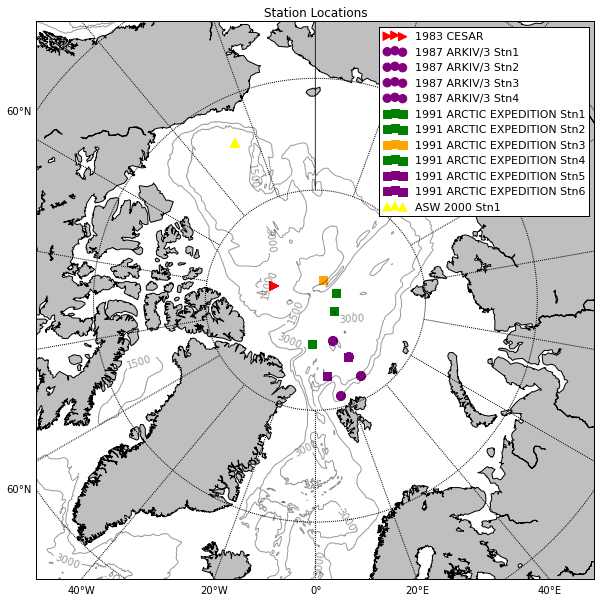

In [55]:
# map

import matplotlib.cm as cm

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

# create Basemap instance.
m = Basemap(projection='npstere',boundinglat=65,lon_0=0,resolution='l')
m.drawcoastlines()
m.fillcontinents(color = '0.75')
m.drawparallels(np.arange(-80.,81.,10.),labels=[1, 0, 0, 0])
m.drawmeridians(np.arange(-180.,181.,20.),labels=[0, 0, 0, 1])

for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    lon = data['long.'];
    name= data['name'][0];
    lat = data['lat.'];
    x,y = m(lon.values,lat.values)
    m.scatter(x,y,color=col[j],marker=marker[j],s=70,label=name)


url = 'http://ferret.pmel.noaa.gov/thredds/dodsC/data/PMEL/etopo5.nc'
etopodata = Dataset(url)
topoin = -etopodata.variables['ROSE'][:]
topoin_ma=np.ma.masked_where(topoin<=0,topoin)
lons = etopodata.variables['ETOPO05_X'][:]
lats = etopodata.variables['ETOPO05_Y'][:]
gridx, gridy = np.meshgrid(lons, lats)
xs,ys = m(gridx,gridy)  

m = m.contour(xs,ys,topoin_ma,linewidth=0.075,colors='black',alpha=0.4)
plt.clabel(m, fontsize=10, inline=1,fmt = '%1.0f')

plt.title("Station Locations")
plt.legend(loc=1,fontsize=11)

plt.show()

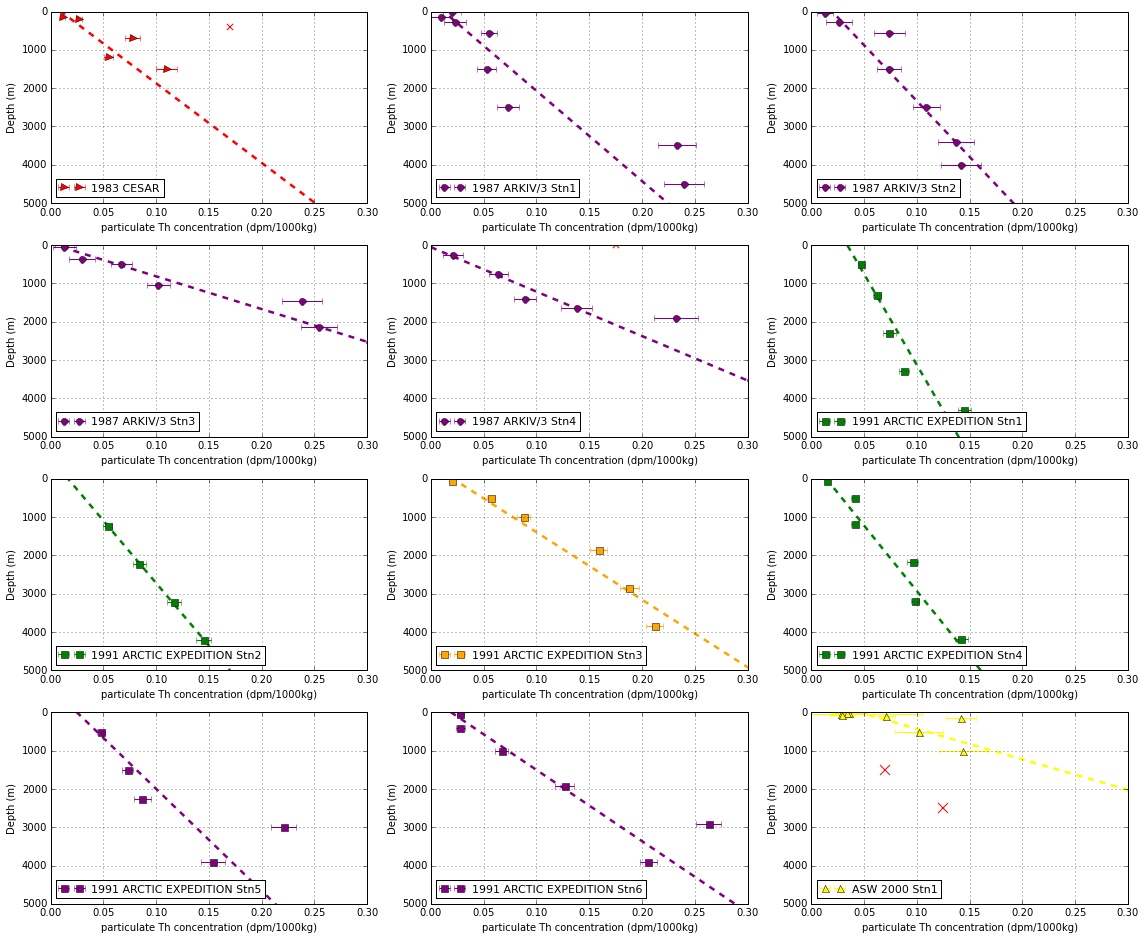

In [56]:
for j in range(file_num):

    data=pd.read_csv(nc_filename[j])

    y0= np.array(data['depth']);x0=np.array(data['230Th part.']);
    lon = data['long.'];lat = data['lat.'];name= data['name'][0];
    err0 =data['Th_part_err']
    
    x=np.ma.masked_where(x0<=0,x0); y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    x=x.compressed();y=y.compressed();err=err.compressed()
    
    if j==0:
        x=np.delete(x,[2],0)
        y=np.delete(y,[2],0)
        err=np.delete(err,[2],0)
    if j==4:
        x=np.delete(x,0,0)
        y=np.delete(y,0,0)
        err=np.delete(err,0,0)
    if j==11:

        x=np.delete(x,-2,0)
        y=np.delete(y,-2,0)
        err=np.delete(err,-2,0)
        x=np.delete(x,-1,0)
        y=np.delete(y,-1,0)
        err=np.delete(err,-1,0)
    
    y2 = sm.add_constant(y,prepend=False)

    part_wls = sm.WLS(x, y2, weights=1./err**2).fit() #have intercept
    ftest   = sm.WLS(x, y, weights=1./err**2).fit()  #do not have intercept


    model1=np.sum(ftest.resid**2/err**2)
    model2=np.sum(part_wls.resid**2/err**2)
    rss1[j]=model1
    rss2[j]=model2
    
    p1 = 1
    p2 = 2
    n = len(x)
    F = ( model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)
    
    WLS_err1[j,:] = part_wls.bse[0]
    WLS_coef1[j,:] = part_wls.params[0]
    WLS_coefc[j,:]=part_wls.params[1]
    WLS_errc[j,:] = part_wls.bse[1]
    sinking_rate[j]=0.0267/part_wls.params[0]
    pre_err1=0.0267/(WLS_coef1[j,:]-WLS_err1[j,:])
    err1[j]=pre_err1-sinking_rate[j]

    
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*23)#Spectral(j*23)
    ax.plot([0, 0.3],[0, 0.3]/part_wls.params[0]-part_wls.params[1]/part_wls.params[0],\
            '--.',c=col[j],linewidth=2.5)#,label='df2')
    ax.errorbar(x, y,xerr=err, fmt=marker[j],markersize=7,c=col[j],label=name)
    if j==0:
        ax.scatter(x0[3],y0[3],marker='x',c='r',s=40)
    if j==4:
        ax.scatter(x0[0],y0[0],marker='x',c='r',s=40)
    if j==11:
        ax.scatter(x0[-2:],y0[-2:],marker='x',c='r',s=100)
    ax.legend(loc=3,fontsize=11)
    
    ax.set_ylim([0, 5000])
    ax.set_xlim([0, 0.3])
    plt.ylabel('Depth (m)')
    plt.xlabel('particulate Th concentration (dpm/1000kg)')

    plt.gca().invert_yaxis()
    plt.grid()
    plt.tight_layout()

plt.show()

#fitting the diss. Th

####(1) Change into fit Q-C{1}K{-1}-K{-1}Qz/S

In [57]:
WLS_err2=np.empty([file_num,1]);

Kvalue=np.empty([file_num,1]); err2=np.empty([file_num,1])
Kvalue_=np.empty([file_num,1]);err2_=np.empty([file_num,1])
Jvalue_=np.empty([file_num,1]);

Jvalue=np.empty([file_num,1])
WLS_coef2=np.empty([file_num,1])
Kapa=np.empty([file_num,1])

[ 0.06592102] [ 0.04251334] [ 0.11245661] [ 0.02601411]
[ 0.1654963] [ 0.09080588] [ 0.23205495] [ 0.05780263]
[ 0.13525824] [ 0.06586654] [ 0.40716898] [ 0.28380918]
[ 0.3801561] [ 0.14262473] [ 0.41683346] [ 0.08782781]
[ 0.39417757] [ 0.33027194] [ 0.35831042] [ 0.10362137]
[ 0.06824489] [ 0.02741948] [ 0.10357334] [ 0.05588316]
[ 0.09575117] [ 0.03975759] [ 0.11690332] [ 0.11054482]
[ 0.04473239] [ 0.01164806] [ 0.05341924] [ 0.01654835]
[ 0.13250355] [ 0.02980907] [ 0.17381974] [ 0.04104657]
[ 0.07427739] [ 0.0425701] [ 0.10732389] [ 0.03212563]
[ 0.1138102] [ 0.04292337] [ 0.16682279] [ 0.04329646]
[ 0.13936087] [ 0.10667017] [ 0.28711274] [ 0.10762316]


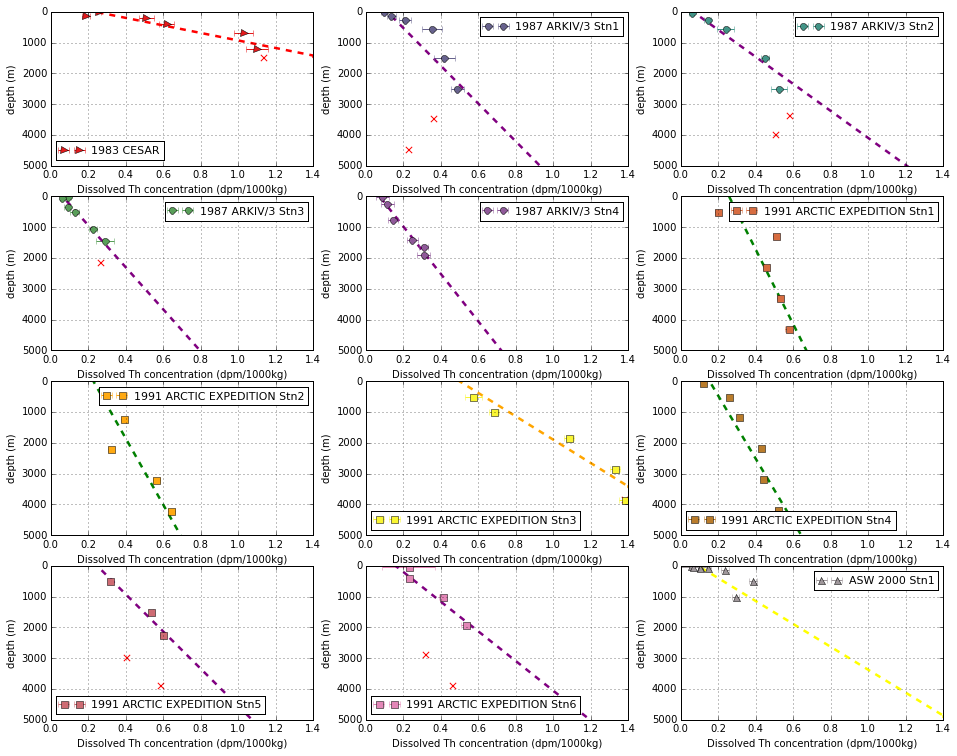

In [58]:
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y0= data['depth'];
    x0= data['230Th diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err0 =data['Th_diss_err']

    x=np.ma.masked_where(x0<=0,x0)
    y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()

    
    if j==7:
        x=np.delete(x,0,0)
        y=np.delete(y,0,0)
        err=np.delete(err,0,0)    
    if j==0 or j==3: #or j==7:
        x=np.delete(x,-1,0)
        y=np.delete(y,-1,0)
        err=np.delete(err,-1,0)
    if j==1 or j==2 or j==10 or j==9:
        index=[len(x)-2,len(x)-1]
        x=np.delete(x,index)
        y=np.delete(y,index)
        err=np.delete(err,index)
        
        
    if j==11:

        x=np.delete(x,-2,0)
        y=np.delete(y,-2,0)
        err=np.delete(err,-2,0)
        x=np.delete(x,-1,0)
        y=np.delete(y,-1,0)
        err=np.delete(err,-1,0)
        
    y2=y
    
    #fit: model2
    y3 = sm.add_constant(y2,prepend=False)  
    diss_wls = sm.WLS(x,y3, weights=1./err**2).fit() 

    
    Q=0.0267
    a=diss_wls.params[0] #slope
    b=diss_wls.params[1] #cons.
    
    Kvalue[j] =Q**2/(b*Q+WLS_coefc[j,:]*a*sinking_rate[j])
    Kvalue_[j]=Q/b
    err2_[j]=Q/(b-diss_wls.bse[1])-Kvalue_[j]
    

    
    pre=Q**2/((b*Q+WLS_coefc[j,:]*a*sinking_rate[j])**2)
    pre_err2=abs(Q*pre*diss_wls.bse[1])+abs(a*WLS_coefc[j,:]*pre*err1[j])+abs(a*sinking_rate[j]*WLS_errc[j,:]*pre)
    err2[j]=pre_err2
    
    print Kvalue[j],err2[j],Kvalue_[j],err2_[j]
    
    
    Jvalue[j]=a*sinking_rate[j]/Q*Kvalue[j]
    Jvalue_[j]=a*sinking_rate[j]/Q*Kvalue_[j]

    err3=abs(Kvalue[j]*sinking_rate[j]/Q*diss_wls.bse[0])
    err3=err3+abs(a*sinking_rate[j]/Q*err2[j])+abs(a*Kvalue[j]/Q*err1[j])


    
    WLS_coef2[j]=diss_wls.params[0]
    WLS_err2[j]=diss_wls.bse[0]
    #err2=diss_wls.bse[0]/diss_wls.params[0]*Kvalue[j]
    
    #fit: model1
    ftest=sm.WLS(x, y2, weights=1./err**2).fit()     
    
    #calculate weighted resid. sum
    resid1=ftest.resid**2/err**2                
    model1=np.sum(resid1)

    resid2=diss_wls.resid**2/err**2
    model2=np.sum(resid2)
    
    #prepare data to recalculate the whole profile later
    rss1[j]=model1                
    rss2[j]=model2

    #f_test
    p1 = 1
    p2 = 2
    n = len(x)
    F = (model1 - model2)/model2*(n-p2)/(p2-p1)
    p = 1.0 - scist.cdf(F,p2-p1,n-p2)

    
    #plot
    ax = plt.figure(1,figsize=(16,16))
    ax = plt.subplot(5,3,j+1)
    cc=cm.Set1(j*23)
    #ax.plot(y2, diss_wls.fittedvalues, '--.',c=cc,linewidth=1.5,label='df2')
    ax.plot([0, 1.4],[0, 1.4]/diss_wls.params[0]-diss_wls.params[1]/diss_wls.params[0], '--.',c=col[j],linewidth=2.5)
    if j==0 or j==3 or j==7 or j==1 or j==2 or j==10 or j==9:
        ax.scatter(x0[(len(x0)-1)],y0[(len(x0)-1)],marker='x',c='r',s=40)
    if j==1 or j==2 or j==10 or j==9:
        ax.scatter(x0[(len(x0)-2)],y0[(len(x0)-2)],marker='x',c='r',s=40)
    ax.errorbar(x,y2,xerr=err, fmt=marker[j],markersize=7,c=cc,label=name)

    ax.legend(loc=0,fontsize=11)

    ax.set_xlim([0, 1.40]);ax.set_ylim([0, 5000])
    plt.xlabel('Dissolved Th concentration (dpm/1000kg)')
    plt.ylabel('depth (m)')
    plt.grid()
    plt.gca().invert_yaxis() 
plt.show()

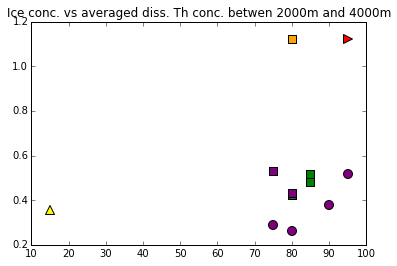

In [59]:
i= np.array([95,90,95,80,75,85,85,80,80,75,80,15]) 
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    
    y0= data['depth'];
    x0= data['230Th diss.'];
    name= data['name'][0];
    lon = data['long.'];
    lat = data['lat.'];
    err0 =data['Th_diss_err']

    x=np.ma.masked_where(x0<=0,x0)
    y=np.ma.masked_where(x0<=0,y0)
    err=np.ma.masked_where(x0<=0,err0)
    
    
    for num in range (len(y)):
        if y[num]<1000:
            x[num]=np.ma.masked
            y[num]=np.ma.masked
            err[num]=np.ma.masked
    cc=cm.Set1(j*23)        
    x=x.compressed()
    y=y.compressed()
    err=err.compressed()
    aver_x=np.average(x,axis=0)
    plt.scatter(i[j],aver_x,c=col[j],marker=marker[j],s=80)
    plt.hold(True)
    plt.title('Ice conc. vs averaged diss. Th conc. betwen 2000m and 4000m')
plt.show()

# WLS: sinking rate and the ice concentration

In [60]:
i_summer= np.array([93,93,93,84,77.3,90,89,88,88.3,82.3,81.7,31.7]) # whole summer average in two years

i= np.array([90,89,85,81,69,86,83,80,71,75,80,15])# lowest in one point


err1=(WLS_err1/WLS_coef1)*1/WLS_coef1*0.0267
sinking_rate=numpy.append(sinking_rate,500)
i=numpy.append(i,0)
i_summer=numpy.append(i_summer,0)
err1=numpy.append(err1,0.0001)


#i= np.array([96.4,95.2,91.2,88.8,97.2,98,98,97.6,97.6,95.6,95.2,97.2]) #poster
#marker=      ['o','o','o','o',   '^','s','s','s','s','s', 's','D','D','>']

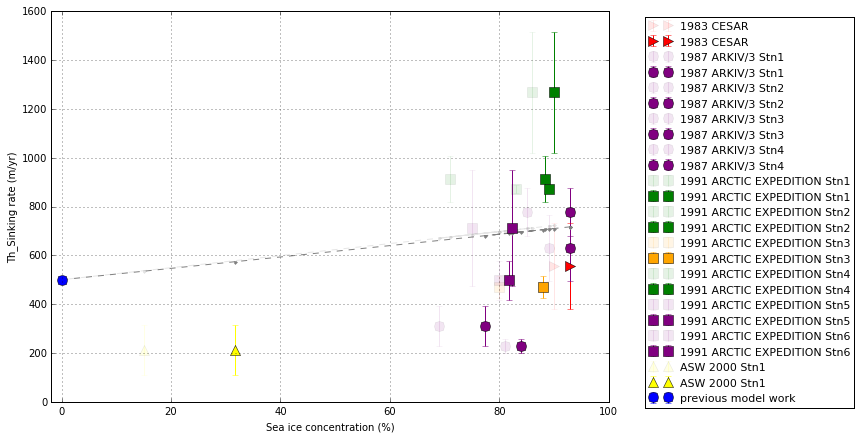

In [61]:


i2 = sm.add_constant(i,prepend=False)
i_summer2 = sm.add_constant(i_summer,prepend=False)

res_wls3 = sm.WLS(sinking_rate,i2,weights=1./err1**2).fit() 
summer = sm.WLS(sinking_rate,i_summer2,weights=1./err1**2).fit() 

fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls3.fittedvalues, '--.',color='grey',alpha=0.2)
ax.plot(i_summer, summer.fittedvalues, '--.',color='grey'  ,alpha=1)
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=col[j],label=name,alpha=0.1)
    errorbar(i_summer[j],sinking_rate[j],yerr=err1[j],fmt=marker[j],markersize=10,c=col[j],label=name)

ax.errorbar(i[-1],sinking_rate[-1], yerr=err1[-1], fmt='o',markersize=10,c='blue',label='previous model work')
ax.legend(loc=0, fontsize=11,bbox_to_anchor=(1.45,1))
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Th_Sinking rate (m/yr)')

ax.set_xlim([-2, 100])
plt.grid()
plt.show()

In [62]:
print res_wls3.summary()

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.368
Model:                            WLS   Adj. R-squared:                  0.311
Method:                 Least Squares   F-statistic:                     6.419
Date:                Mon, 21 Mar 2016   Prob (F-statistic):             0.0278
Time:                        09:35:58   Log-Likelihood:                -42.072
No. Observations:                  13   AIC:                             88.14
Df Residuals:                      11   BIC:                             89.27
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             2.4693      0.975      2.534      0.028         0.324     4.614
const        500.0000      0.001   7.47e+05      0.0

#  K value and the ice concentration

### Method1

In [63]:
Kvalue_=numpy.append(Kvalue_,0.75)
err2_=numpy.append(err2_,0.0001)

res_wls4 = sm.WLS(Kvalue_, i2, weights=1./err2_**2).fit()
summer_k = sm.WLS(Kvalue_, i_summer2, weights=1./err2_**2).fit()

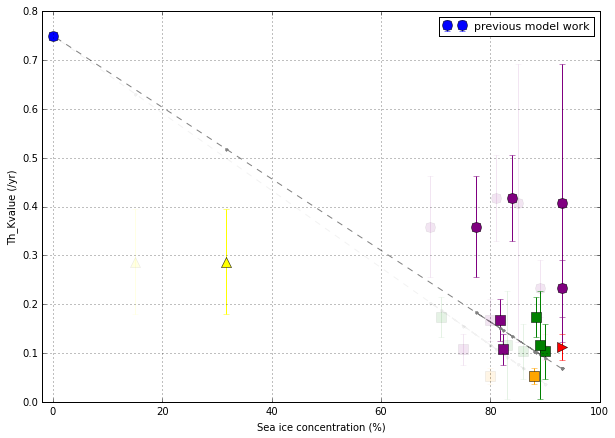

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.982
Model:                            WLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     584.6
Date:                Mon, 21 Mar 2016   Prob (F-statistic):           6.92e-11
Time:                        09:35:58   Log-Likelihood:                -28.771
No. Observations:                  13   AIC:                             61.54
Df Residuals:                      11   BIC:                             62.67
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1            -0.0079      0.000    -24.179      0.000        -0.009    -0.007
const          0.7500      0.000   3117.961      0.0

In [64]:
fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, res_wls4.fittedvalues,  '--.',color='grey',alpha=0.1)
ax.plot(i_summer, summer_k.fittedvalues,  '--.',color='grey')

for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i[j],Kvalue_[j],yerr=err2_[j],fmt=marker[j],markersize=10,c=col[j],alpha=0.1)#,label=name)
    errorbar(i_summer[j],Kvalue_[j],yerr=err2_[j],fmt=marker[j],markersize=10,c=col[j])
    
errorbar(i[-1],Kvalue_[-1], yerr=err2_[-1], fmt='o',markersize=10,c='blue',label='previous model work')
ax.legend(loc=0,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Th_Kvalue (/yr)')
ax.set_xlim([-2, 100])
plt.grid()
plt.show()
print res_wls4.summary() 

#  J value and the ice concentration

In [65]:
err2=WLS_err2/WLS_coef2*Jvalue

i=np.delete(i,-1)
i2 = sm.add_constant(i,prepend=False)
mod_wls4 = sm.WLS(Jvalue_, i2, weights=1./err2**2).fit()


i_summer=np.delete(i_summer,-1)
i_summer2 = sm.add_constant(i_summer,prepend=False)
summer_j = sm.WLS(Jvalue_, i_summer2, weights=1./err2**2).fit()

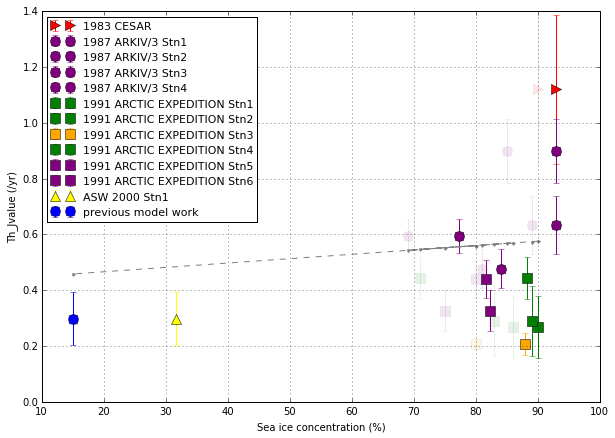

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.003
Model:                            WLS   Adj. R-squared:                 -0.097
Method:                 Least Squares   F-statistic:                   0.02687
Date:                Mon, 21 Mar 2016   Prob (F-statistic):              0.873
Time:                        09:35:59   Log-Likelihood:                -38.746
No. Observations:                  12   AIC:                             81.49
Df Residuals:                      10   BIC:                             82.46
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0016      0.010      0.164      0.873        -0.020     0.023
const          0.4348      0.731      0.595      0.5

/home/xiaoxiny/anaconda/lib/python2.7/site-packages/scipy/stats/stats.py:1205: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  int(n))


In [66]:
fig, ax = plt.subplots(1,figsize=(10,7))
ax.plot(i, mod_wls4.fittedvalues,  '--.',color='grey')
for j in range(file_num):
    data=pd.read_csv(nc_filename[j])
    name= data['name'][0];
    errorbar(i_summer[j],Jvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],label=name)
    errorbar(i[j],Jvalue[j],yerr=err2[j],fmt=marker[j],markersize=10,c=col[j],alpha=0.1)
    
errorbar(i[-1],Jvalue[-1], yerr=err2[-1], fmt='o',markersize=10,c='blue',label='previous model work')
ax.legend(loc=2,fontsize=11)
plt.xlabel('Sea ice concentration (%)')
plt.ylabel('Th_Jvalue (/yr)')
#ax.set_xlim([-2, 100])
plt.grid()
plt.show()
print mod_wls4.summary()